In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# fpath = "C:/Users/stell/UGRP_Github_desktop/UGRP/individual_workspace/CHJ/"

before_data = np.load("multichannel_signal" + ".npy")
during_data = np.load("contaminated_by_realistic_correlatied" + ".npy")

n_channels, n_samples = during_data.shape

def pearson_correlation(x, y):
    """Calculate Pearson's correlation coefficient between two signals."""
    return np.corrcoef(x, y)[0, 1]

def sign_function(correlation, threshold=0.75):
    """Redefine the sign function based on Pearson's correlation coefficient and threshold.
    Returns 1 if correlation > threshold, otherwise returns 0."""
    return 1 if correlation > threshold else 0

def nlms_filter(input_signal, reference_signal, filter_length=10, step_size=0.1):
    """NLMS filter implementation."""
    filter_weights = np.zeros(filter_length)
    output_signal = np.zeros_like(input_signal)

    for n in range(filter_length, len(input_signal)):
        input_vector = input_signal[n-filter_length:n]
        reference_vector = reference_signal[n-filter_length:n]
        
        output_signal[n] = np.dot(filter_weights, input_vector)
        error = input_signal[n] - output_signal[n]
        
        norm = np.dot(input_vector, input_vector) + 1e-6  # To avoid division by zero
        filter_weights += (step_size / norm) * error * input_vector

    return output_signal

def compute_acar(data, filter_length=10, step_size=0.1, threshold=0.75, span=5):
    """
    Adaptive Common Average Reference (ACAR) using a modified NLMS filter.
    
    Parameters:
    - data: 2D numpy array (channels x timepoints)
    - filter_length: Length of the NLMS filter
    - step_size: Step size for NLMS filter
    - threshold: Pearson correlation coefficient threshold
    - span: Span for moving average filter
    
    Returns:
    - acar_data: 2D numpy array with ACAR applied
    """
    num_channels = data.shape[0]
    acar_data = np.zeros_like(data)

    for i in range(num_channels):
        correlations = np.array([pearson_correlation(data[i], data[j]) for j in range(num_channels) if i != j])
        selected_channels = [j for j, corr in enumerate(correlations) if i != j and sign_function(corr, threshold) > 0]
        
        if selected_channels:
            reference_signal = np.mean(data[selected_channels, :], axis=0)
        else:
            reference_signal = np.mean(data, axis=0)

        acar_data[i, :] = nlms_filter(data[i, :], reference_signal, filter_length, step_size)
        
        # Apply moving average filter with span of 5
        acar_data[i, :] = np.convolve(acar_data[i, :], np.ones(span)/span, mode='same')

    return acar_data

ACARed_data = compute_acar(during_data)

# 채널 정보
stim_ch = 11
target_ch = 12

fs = 2000  # 샘플링 주파수
frequencies = np.linspace(-fs/2, fs/2, n_samples)  # 주파수 범위 설정
time = np.arange(n_samples) / fs # 시간 범위 설정

In [2]:
print("Inf in during_data:", np.isinf(during_data).any())
print("Inf in ACARed_data:", np.isinf(ACARed_data).any())
print("NaN in during_data:", np.isnan(during_data).any())
print("NaN in ACARed_data:", np.isnan(ACARed_data).any())

Inf in during_data: False
Inf in ACARed_data: False
NaN in during_data: False
NaN in ACARed_data: False


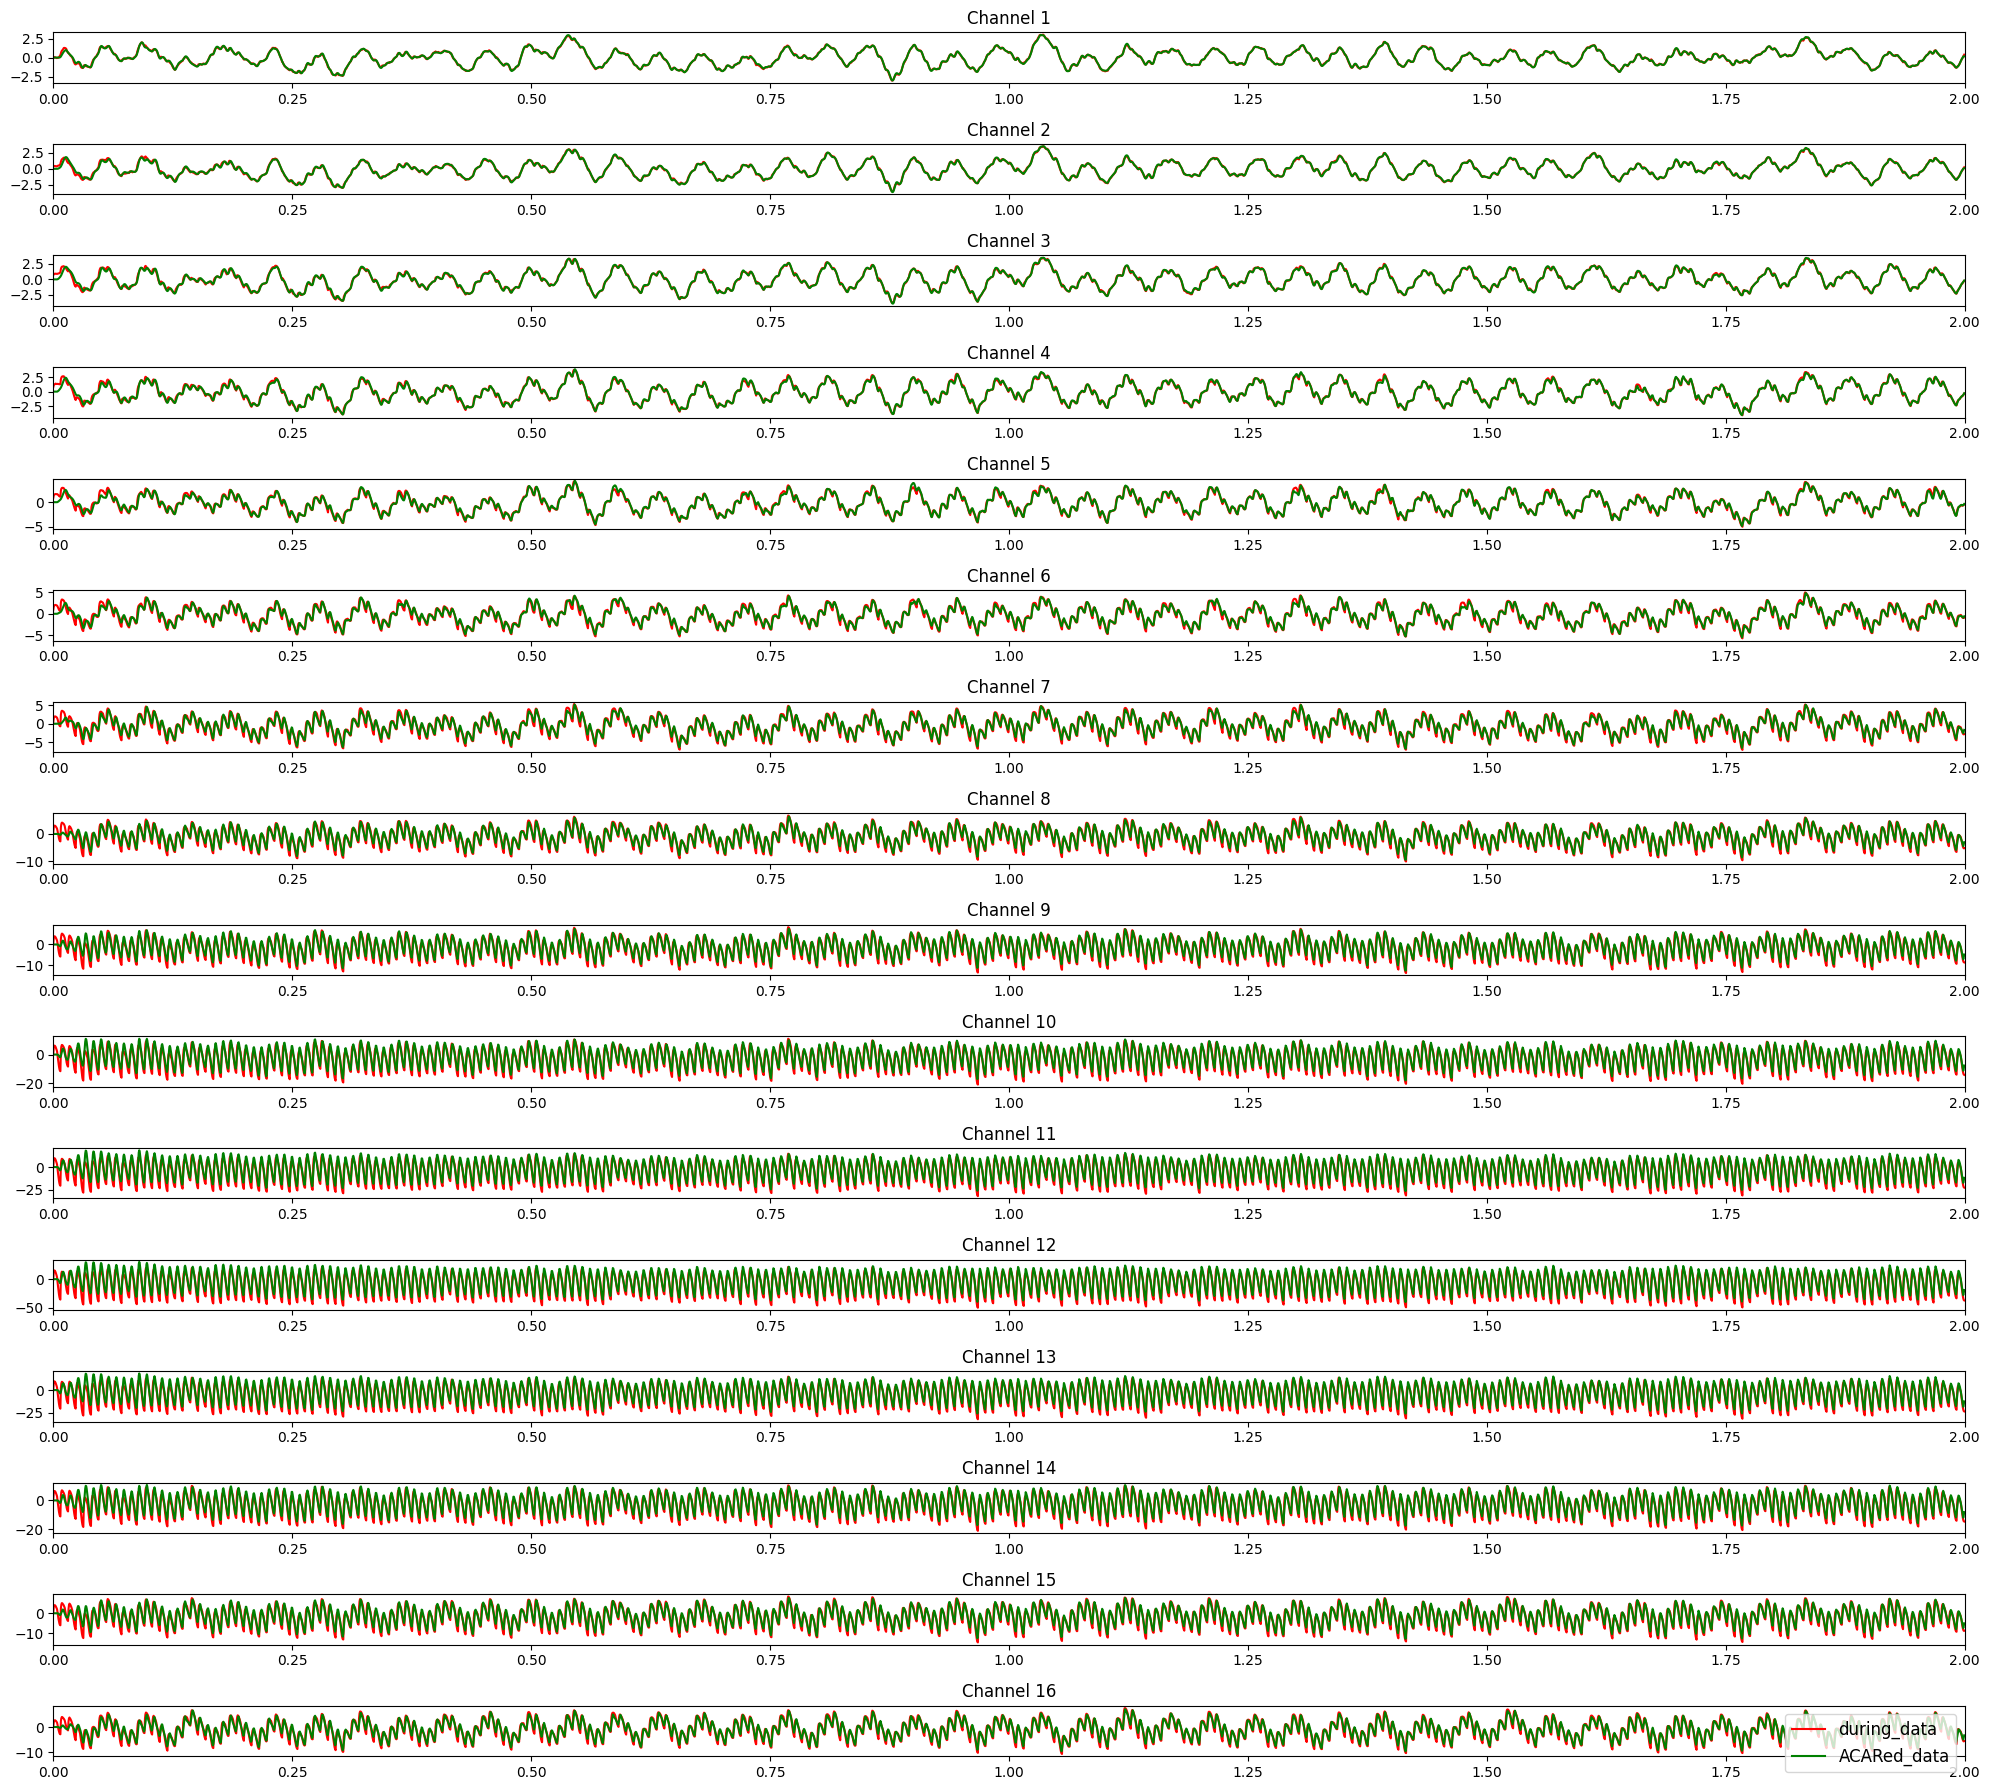

In [6]:
# 결과 출력 - 전체 채널
plt.figure(figsize=(20, 18))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i+1)
    plt.plot(time, during_data[i, :], 'r', label='during_data')
    plt.plot(time, ACARed_data[i, :], 'g', label='ACARed_data')
    plt.xlim(0, 2)
    plt.title(f'Channel {i+1}')
    
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

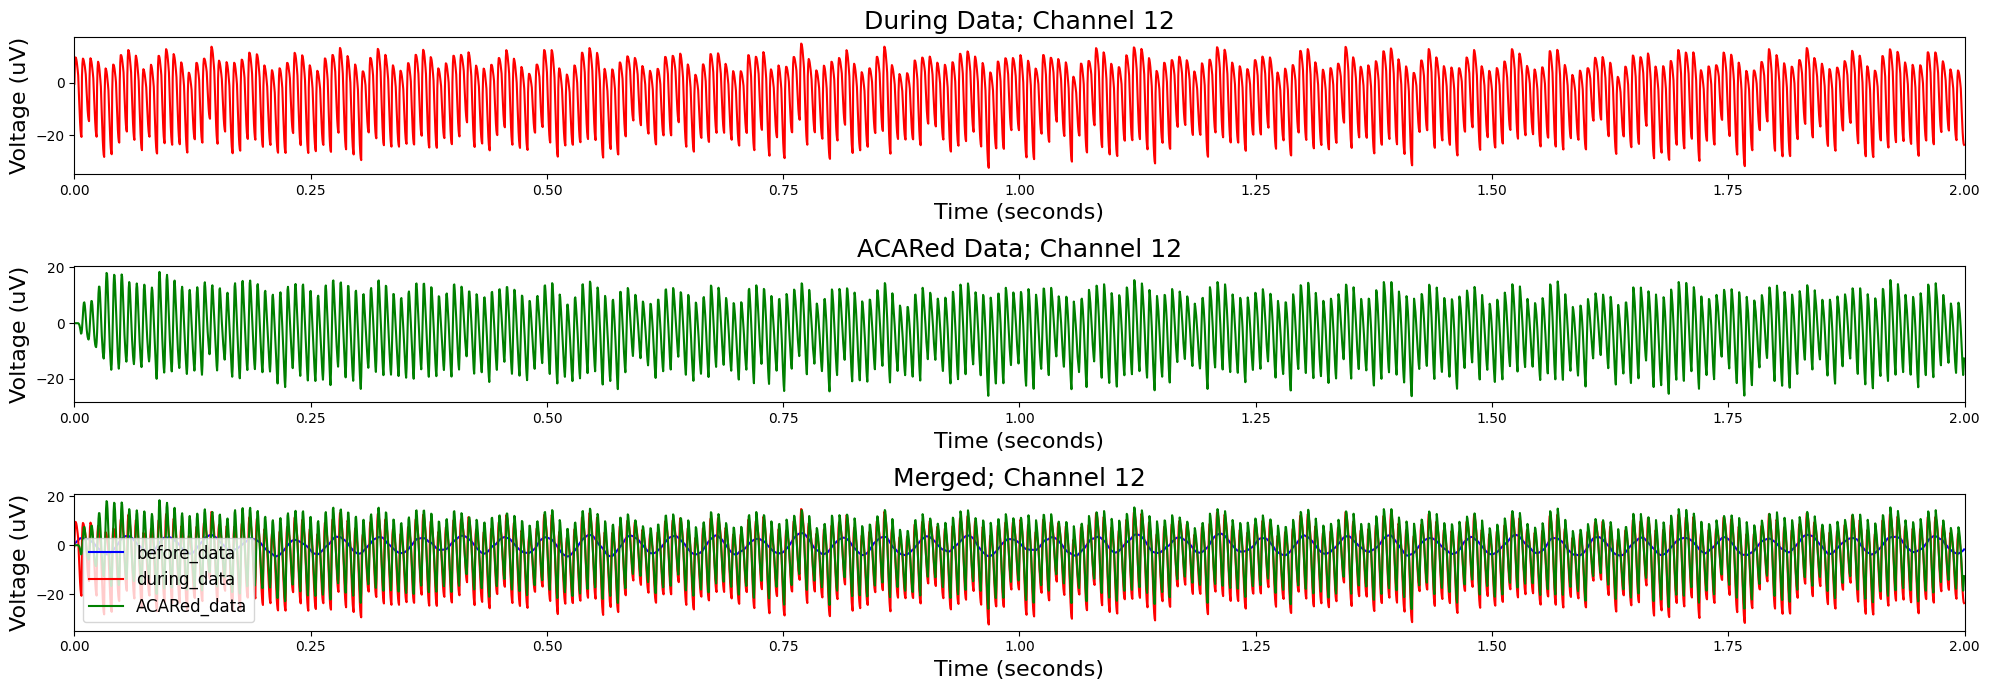

In [7]:
# 결과 플로팅 - 내가 볼 채널만
plt.figure(figsize=(20, 7))

# 원본 데이터
plt.subplot(3, 1, 1)
plt.plot(time, during_data[target_ch, :], 'r')
plt.xlim(0, 2)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'During Data; Channel {target_ch}', fontsize=18)

# 필터된 데이터
plt.subplot(3, 1, 2)
plt.plot(time, ACARed_data[target_ch, :], 'g')
plt.xlim(0, 2)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'ACARed Data; Channel {target_ch}', fontsize=18)

# Time domain
plt.subplot(3, 1, 3)
plt.plot(time, before_data[target_ch, :], 'b', label='before_data')
plt.plot(time, during_data[target_ch, :], 'r', label='during_data')
plt.plot(time, ACARed_data[target_ch, :], 'g', label='ACARed_data')
plt.xlim(0, 2)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'Merged; Channel {target_ch}', fontsize=18)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

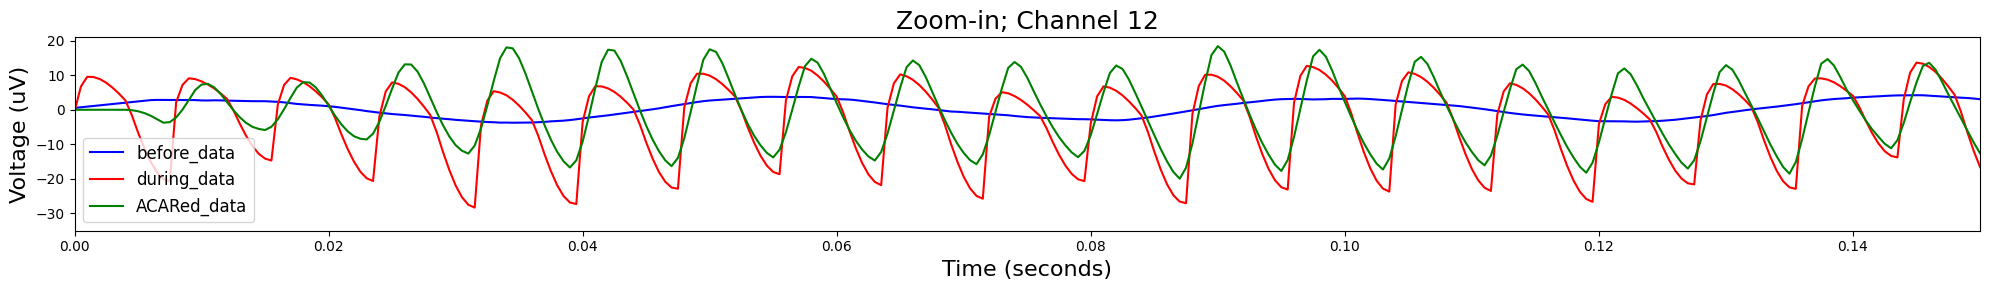

In [8]:
# 결과 플로팅 - 줌인
plt.figure(figsize=(20, 3))

start_t = 0
end_t = 0.15

plt.plot(time, before_data[target_ch, :], 'b', label='before_data')
plt.plot(time, during_data[target_ch, :], 'r', label='during_data')
plt.plot(time, ACARed_data[target_ch, :], 'g', label='ACARed_data')
plt.xlim(start_t, end_t)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'Zoom-in; Channel {target_ch}', fontsize=18)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

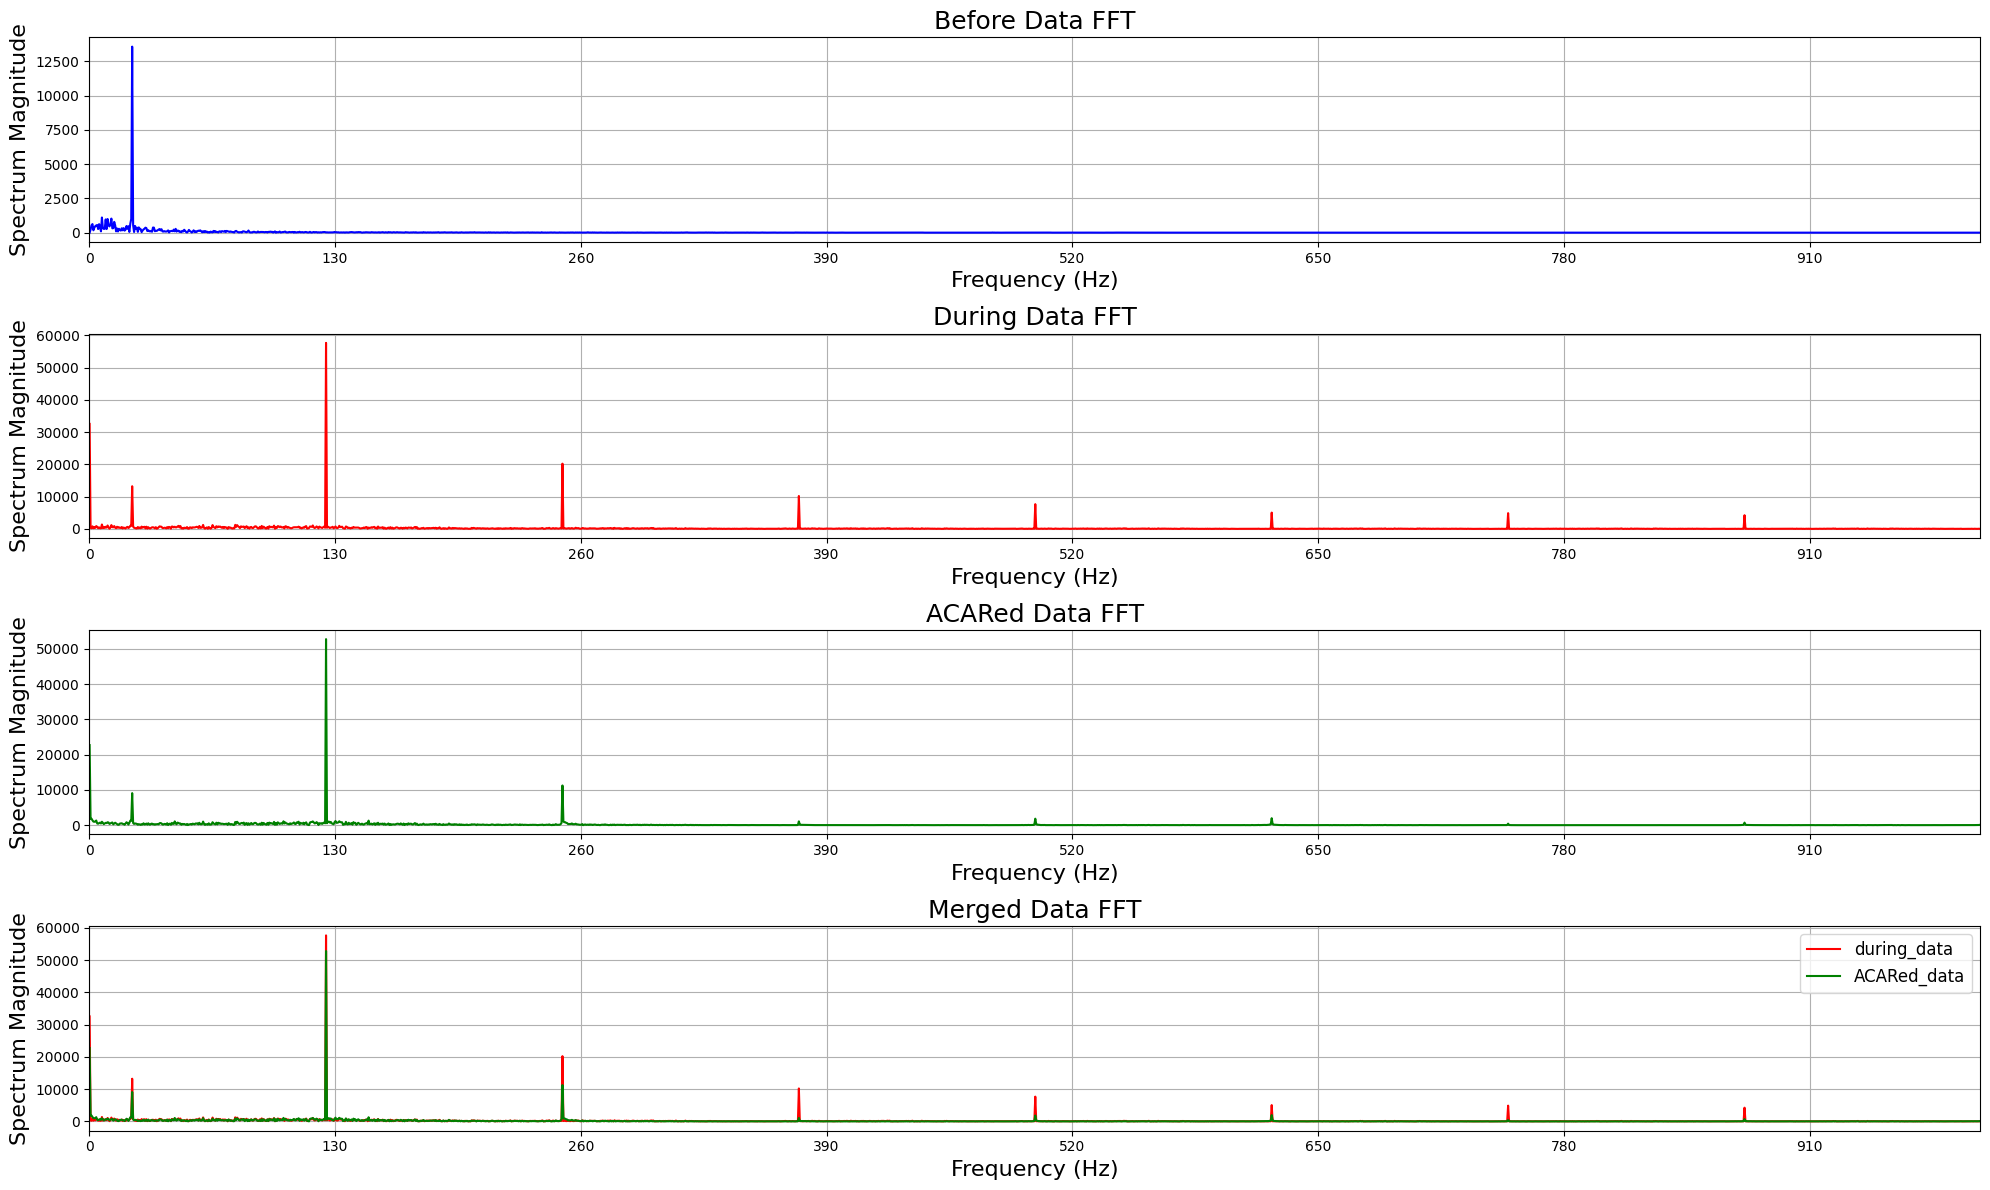

In [9]:
# 푸리에 변환 수행
before_fft_result = np.fft.fftshift(np.fft.fft(before_data, axis=1), axes=1)
during_fft_result = np.fft.fftshift(np.fft.fft(during_data, axis=1), axes=1)
ACARed_fft_result = np.fft.fftshift(np.fft.fft(ACARed_data, axis=1), axes=1)

# 양수 부분의 주파수와 푸리에 변환 결과 가져오기
positive_frequencies = frequencies[n_samples//2:]
positive_before_fft_result = 2 * before_fft_result[:, n_samples//2:]
positive_during_fft_result = 2 * during_fft_result[:, n_samples//2:]
positive_ACARed_fft_result = 2 * ACARed_fft_result[:, n_samples//2:]

# 푸리에 스펙트럼 플로팅
plt.figure(figsize=(20, 12))

# 자극 전 데이터
plt.subplot(4, 1, 1)
plt.plot(positive_frequencies, np.abs(positive_before_fft_result[target_ch, :]), 'b', label='before_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('Before Data FFT', fontsize=18)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

# 원본 데이터
plt.subplot(4, 1, 2)
plt.plot(positive_frequencies, np.abs(positive_during_fft_result[target_ch, :]), 'r', label='during_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('During Data FFT', fontsize=18)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

# 필터된 데이터
plt.subplot(4, 1, 3)
plt.plot(positive_frequencies, np.abs(positive_ACARed_fft_result[target_ch, :]), 'g', label='ACARed_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('ACARed Data FFT', fontsize=18)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

# Freq. domain
plt.subplot(4, 1, 4)
plt.plot(positive_frequencies, np.abs(positive_during_fft_result[target_ch, :]), 'r', label='during_data')
plt.plot(positive_frequencies, np.abs(positive_ACARed_fft_result[target_ch, :]), 'g', label='ACARed_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('Merged Data FFT', fontsize=18)
plt.legend(fontsize=12)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

plt.tight_layout()
plt.show()

In [10]:
# 평가
print("Time domain")
mae_time = mean_absolute_error(during_data[target_ch, :], ACARed_data[target_ch, :])
mse_time = mean_squared_error(during_data[target_ch, :], ACARed_data[target_ch, :])
print(f"Mean Absolute Error: {mae_time:.4f}")
print(f"Mean Squared Error: {mse_time:.4f}")

print("\nFrequency domain")

dft_magnitude_during = np.abs(positive_during_fft_result)**2
dft_magnitude_ACARed = np.abs(positive_ACARed_fft_result)**2

# 로그 변환: 0 값 처리
dft_magnitude_during[dft_magnitude_during <= 0] = np.finfo(float).eps
dft_magnitude_ACARed[dft_magnitude_ACARed <= 0] = np.finfo(float).eps

log_dft_magnitude_during = np.log10(dft_magnitude_during)
log_dft_magnitude_ACARed = np.log10(dft_magnitude_ACARed)

mae_freq = mean_absolute_error(log_dft_magnitude_during, log_dft_magnitude_ACARed)
mse_freq = mean_squared_error(log_dft_magnitude_during, log_dft_magnitude_ACARed)

print(f"Mean Absolute Error: {mae_freq:.4f}")
print(f"Mean Squared Error: {mse_freq:.4f}")

Time domain
Mean Absolute Error: 3.3444
Mean Squared Error: 17.9068

Frequency domain
Mean Absolute Error: 0.8989
Mean Squared Error: 1.2818
